##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [5]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os  

In [6]:
def Curve(x,a,b,c):
    return (a*x**2+b*x+c)

def TTV_Split(iteration,Memory,X,y,params,X_fill):
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val)

def RunReps(Model,params,pool = None,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv')
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MAE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if params['Prelim_N']==True:
        params['N']=int(y.shape[0]*.8/30)
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MAE.append(metrics.mean_absolute_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MAE.append(metrics.mean_absolute_error(y_val,Yval))
            R2.append(metrics.r2_score(y_val,Yval))
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    return(MAE,R2,RST.Master['TempFill'])

def RunLoop(Runs,model):
    style = {'description_width': 'initial'}
    f = FloatProgress(min=0, max=Runs['N'].count(),description='Finding Best N:',style=style) # instantiate the bar
    display(f) # display the bar
    i = 0
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(model,params,pool)
        MAE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'MAE']=MAE
        Runs.loc[Runs['N']==N,'R2']=R2
        f.value+=params['K']
        MAE = Runs.loc[Runs['MAE']!=0].groupby('N').mean()#.values[0]
        MAE['se'] = Runs.loc[Runs['MAE']!=0,['N','MAE']].groupby('N').sem()#.values[0]
        Val = MAE['MAE'].min()+MAE.loc[MAE['MAE']==MAE['MAE'].min(),'se'].values[0]
        if i > 2:
            if np.asanyarray(MAE).mean()>Val:
                Runs = Runs.loc[Runs['MAE']!=0]
                print('Leaving at ',N)
                break
        i+=1                
    return(Runs)

def N_Nodes(Runs,params,model,plot=False):
    params['Prelim_N']=False
    Runs = RunLoop(Runs,model)
    Group = Runs.groupby('N').mean()
    Group['Count'] = Runs[['N','MAE']].groupby('N').count()
    Group['SD'] = Runs[['N','MAE']].groupby('N').std()
    Group['SE'] = Runs[['N','MAE']].groupby('N').sem()
    Group = Group.reset_index()
    Min = Group.loc[Group['MAE']==Group['MAE'].min()]
    popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MAE'].values)
    N = np.arange(Runs['N'].min(),Runs['N'].max())
    Fit = Curve(N,*popt)
    Max = (Min['MAE']+Min['SE']).values[0]
    try:
        params['N']=N[Fit<Max].min()
    except:
        print('Fitting failed to produce meaningful results')
        params['N'] = Group.loc[Group['MAE']<+Min['MAE'].values[0]+Min['SE'].values[0],'N'].values[0]
        pass
    
    if plot == True:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.scatter(Runs['N'],Runs['MAE'])
        ax.plot(N,Fit,color='r')
        ax.plot(N,N*0+Max,color = 'black')
        plt.grid()
        plt.show()
    return(params,Runs,Group)

def Combos(Model,L,factor=None,BaseFactors=[]):
    Models=[]#BaseFactors#list()
    for c in combinations(Model,L):
        c = list(c)+BaseFactors
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
    print('Models: ',Models)
    return(Models)

def FactorTest(params,FullModel,Runs,BaseFactors = []):
    prog1 = FloatProgress(min=len(BaseFactors), max=len(FullModel+BaseFactors)-1,description='FactorTesting:') # instantiate the bar
    display(prog1) # display the bar
    Scores = pd.DataFrame()
    ModelRuns = pd.DataFrame()
    Start = 1
    for level in range(Start,len(FullModel+BaseFactors)+1):
        if level == 1:
            Models = Combos(FullModel,level)
#         elif BaseFactors != [] and i-Start == 0:
#             Models = Combos(FullModel,level-Start+1,BaseFactors=BaseFactors)
#         elif BaseFactors != [] and i-Start > 0:
#             Models = Combos(FullModel,level-Start+1,factor = Best,BaseFactors=BaseFactors)
        else:
            Models = Combos(FullModel,level,factor = Best,BaseFactors=BaseFactors)
        print('Number of Models: ',len(Models))
        prog2 = FloatProgress(min=0, max=len(Models),description='Level: '+str(level)) # instantiate the bar
        display(prog2) # display the bar
        Values = []
        for j,model in enumerate(Models):
            key = str(level)+'_'+str(j)
            Name = '+'.join(model)
            Results = RunReps(model,params,pool)
            MAE = Results[0]
            R2 = Results[1]
            d = {'Model':'+'.join(model),'MAE':MAE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
            score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
            Scores = Scores.append(score,ignore_index=True)## Might cause problems in older versions
            ModelRuns['Model: '+'+'.join(model)] = Results[2]    
            prog2.value+=1
        Group = Scores.groupby('Key').agg({'Model': 'first','Level': 'first','MAE': 'mean','R2': 'mean'}) 
        Group['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
        Min = Group.loc[Group['Level']==level]
#         print(Min)
        Mod2Beat = Min.loc[Min['MAE'] == Min['MAE'].min()]
        print('Best Model @ Level ',level)
        print(Mod2Beat)
        if level>Start:
            print('Should we exit??', (Mod2Beat['MAE']+Mod2Beat['SE']).values[0],LastMin)
            if (Mod2Beat['MAE']+Mod2Beat['SE']).values[0]>LastMin:
                print('Exit Early')
                Scores = Scores.loc[Scores['Level']<level]
                break
        LastMin = Min['MAE'].min()
        Best = Mod2Beat['Model'].values
        prog1.value+=1
    Group = Scores.groupby('Key').agg({'Model': 'first','Level': 'first','MAE': 'mean','R2': 'mean'})
    Group['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]
    return(Best,Scores,ModelRuns)

def Best_Fill(Best,Runs,Scores,params):
    N = Runs['N']
    NRuns = Runs*0
    NRuns['N']=N
    model = Best[0].split('+')

    params,Runs,Group = N_Nodes(NRuns,params,model,plot=True)
    level = 0
    key = '0_'+str(params['N'])
    Name = '+'.join(Best)
    Results = RunReps(model,params,pool)
    MSE = Results[0]
    R2 = Results[1]
    d = {'Model':'+'.join(model),'MAE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
    score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
    Scores = Scores.append(score,ignore_index=True)
    ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
    print(params['N'])
    return(Scores,ModelRuns)

# The "Optimum" Sized Model

Illisarvik fco2


A Jupyter Widget

Models:  [['H'], ['wind_speed'], ['air_pressure'], ['PPFD_Avg'], ['AirTC_Avg'], ['VPD'], ['Temp'], ['VWC'], ['Sedge'], ['Shrub'], ['Grass'], ['Sparse'], ['Out_of_Basin']]
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  1
        Model       R2       MAE  Level        SE
Key                                              
1_3  PPFD_Avg  0.81696  0.140516      1  0.000634
Models:  [['H', 'PPFD_Avg'], ['wind_speed', 'PPFD_Avg'], ['air_pressure', 'PPFD_Avg'], ['PPFD_Avg', 'AirTC_Avg'], ['PPFD_Avg', 'VPD'], ['PPFD_Avg', 'Temp'], ['PPFD_Avg', 'VWC'], ['PPFD_Avg', 'Sedge'], ['PPFD_Avg', 'Shrub'], ['PPFD_Avg', 'Grass'], ['PPFD_Avg', 'Sparse'], ['PPFD_Avg', 'Out_of_Basin']]
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  2
                   Model        R2       MAE  Level       SE
Key                                                         
2_1  wind_speed+PPFD_Avg  0.850575  0.131233      2  0.00052
Should we exit?? 0.131753156331 0.140515850519
Models:  [['H', 'wind_speed', 'PPFD_Avg'], ['wind_speed', 'air_pressure', 'PPFD_Avg'], ['wind_speed', 'PPFD_Avg', 'AirTC_Avg'], ['wind_speed', 'PPFD_Avg', 'VPD'], ['wind_speed', 'PPFD_Avg', 'Temp'], ['wind_speed', 'PPFD_Avg', 'VWC'], ['wind_speed', 'PPFD_Avg', 'Sedge'], ['wind_speed', 'PPFD_Avg', 'Shrub'], ['wind_speed', 'PPFD_Avg', 'Grass'], ['wind_speed', 'PPFD_Avg', 'Sparse'], ['wind_speed', 'PPFD_Avg', 'Out_of_Basin']]
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  3
                     Model        R2       MAE  Level        SE
Key                                                            
3_0  H+wind_speed+PPFD_Avg  0.877816  0.116208      3  0.000581
Should we exit?? 0.116788333278 0.131233158095
Models:  [['H', 'wind_speed', 'air_pressure', 'PPFD_Avg'], ['H', 'wind_speed', 'PPFD_Avg', 'AirTC_Avg'], ['H', 'wind_speed', 'PPFD_Avg', 'VPD'], ['H', 'wind_speed', 'PPFD_Avg', 'Temp'], ['H', 'wind_speed', 'PPFD_Avg', 'VWC'], ['H', 'wind_speed', 'PPFD_Avg', 'Sedge'], ['H', 'wind_speed', 'PPFD_Avg', 'Shrub'], ['H', 'wind_speed', 'PPFD_Avg', 'Grass'], ['H', 'wind_speed', 'PPFD_Avg', 'Sparse'], ['H', 'wind_speed', 'PPFD_Avg', 'Out_of_Basin']]
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  4
                         Model        R2       MAE  Level       SE
Key                                                               
4_4  H+wind_speed+PPFD_Avg+VWC  0.892584  0.102671      4  0.00162
Should we exit?? 0.10429101273 0.116207783146
Models:  [['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'VWC'], ['H', 'wind_speed', 'PPFD_Avg', 'AirTC_Avg', 'VWC'], ['H', 'wind_speed', 'PPFD_Avg', 'VPD', 'VWC'], ['H', 'wind_speed', 'PPFD_Avg', 'Temp', 'VWC'], ['H', 'wind_speed', 'PPFD_Avg', 'VWC', 'Sedge'], ['H', 'wind_speed', 'PPFD_Avg', 'VWC', 'Shrub'], ['H', 'wind_speed', 'PPFD_Avg', 'VWC', 'Grass'], ['H', 'wind_speed', 'PPFD_Avg', 'VWC', 'Sparse'], ['H', 'wind_speed', 'PPFD_Avg', 'VWC', 'Out_of_Basin']]
Number of Models:  9


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  5
                              Model        R2       MAE  Level       SE
Key                                                                    
5_3  H+wind_speed+PPFD_Avg+Temp+VWC  0.900678  0.100036      5  0.00131
Should we exit?? 0.101345486614 0.10267090579
Models:  [['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'Temp', 'VWC'], ['H', 'wind_speed', 'PPFD_Avg', 'AirTC_Avg', 'Temp', 'VWC'], ['H', 'wind_speed', 'PPFD_Avg', 'VPD', 'Temp', 'VWC'], ['H', 'wind_speed', 'PPFD_Avg', 'Temp', 'VWC', 'Sedge'], ['H', 'wind_speed', 'PPFD_Avg', 'Temp', 'VWC', 'Shrub'], ['H', 'wind_speed', 'PPFD_Avg', 'Temp', 'VWC', 'Grass'], ['H', 'wind_speed', 'PPFD_Avg', 'Temp', 'VWC', 'Sparse'], ['H', 'wind_speed', 'PPFD_Avg', 'Temp', 'VWC', 'Out_of_Basin']]
Number of Models:  8


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  6
                                           Model        R2       MAE  Level  \
Key                                                                           
6_7  H+wind_speed+PPFD_Avg+Temp+VWC+Out_of_Basin  0.896797  0.101638      6   

           SE  
Key            
6_7  0.001535  
Should we exit?? 0.103172875692 0.100035751052
Exit Early
['H+wind_speed+PPFD_Avg+Temp+VWC']       Key  Level       MAE                                   Model        R2
0     1_0      1  0.201393                                       H  0.613369
1     1_0      1  0.201026                                       H  0.603224
2     1_0      1  0.201614                                       H  0.590118
3     1_0      1  0.200790                                       H  0.608688
4     1_0      1  0.201771                                       H  0.614691
5     1_0      1  0.200810                                       H  0.600051
6     1_0      1  0.202671                                  

A Jupyter Widget

Using TensorFlow backend.


Leaving at  140


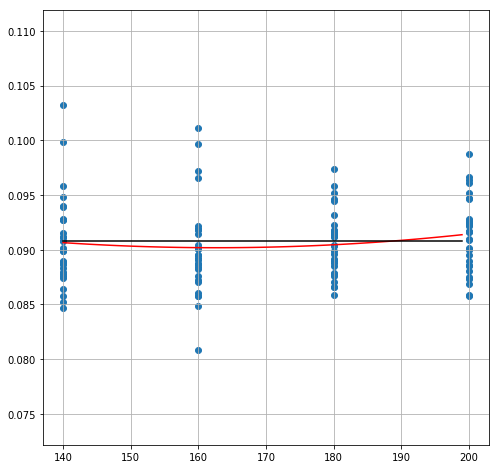

Using TensorFlow backend.


140
Illisarvik fch4


A Jupyter Widget

Models:  [['H'], ['wind_speed'], ['air_pressure'], ['PPFD_Avg'], ['AirTC_Avg'], ['VPD'], ['Temp'], ['VWC'], ['Sedge'], ['Shrub'], ['Grass'], ['Sparse'], ['Out_of_Basin']]
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  1
     Model         R2       MAE  Level        SE
Key                                             
1_8  Sedge -12.400752  0.480219      1  0.000805
Models:  [['H', 'Sedge'], ['wind_speed', 'Sedge'], ['air_pressure', 'Sedge'], ['PPFD_Avg', 'Sedge'], ['AirTC_Avg', 'Sedge'], ['VPD', 'Sedge'], ['Temp', 'Sedge'], ['VWC', 'Sedge'], ['Sedge', 'Shrub'], ['Sedge', 'Grass'], ['Sedge', 'Sparse'], ['Sedge', 'Out_of_Basin']]
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  2
         Model        R2       MAE  Level        SE
Key                                                
2_7  VWC+Sedge -3.771755  0.396932      2  0.006559
Should we exit?? 0.403491106742 0.48021912882
Models:  [['H', 'VWC', 'Sedge'], ['wind_speed', 'VWC', 'Sedge'], ['air_pressure', 'VWC', 'Sedge'], ['PPFD_Avg', 'VWC', 'Sedge'], ['AirTC_Avg', 'VWC', 'Sedge'], ['VPD', 'VWC', 'Sedge'], ['Temp', 'VWC', 'Sedge'], ['VWC', 'Sedge', 'Shrub'], ['VWC', 'Sedge', 'Grass'], ['VWC', 'Sedge', 'Sparse'], ['VWC', 'Sedge', 'Out_of_Basin']]
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  3
               Model        R2       MAE  Level        SE
Key                                                      
3_8  VWC+Sedge+Grass -0.236538  0.346632      3  0.000686
Should we exit?? 0.347317567409 0.396931898757
Models:  [['H', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'VWC', 'Sedge', 'Grass'], ['air_pressure', 'VWC', 'Sedge', 'Grass'], ['PPFD_Avg', 'VWC', 'Sedge', 'Grass'], ['AirTC_Avg', 'VWC', 'Sedge', 'Grass'], ['VPD', 'VWC', 'Sedge', 'Grass'], ['Temp', 'VWC', 'Sedge', 'Grass'], ['VWC', 'Sedge', 'Shrub', 'Grass'], ['VWC', 'Sedge', 'Grass', 'Sparse'], ['VWC', 'Sedge', 'Grass', 'Out_of_Basin']]
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  4
                    Model        R2       MAE  Level        SE
Key                                                           
4_6  Temp+VWC+Sedge+Grass  0.169222  0.317711      4  0.001378
Should we exit?? 0.319088677377 0.346631913431
Models:  [['H', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'Temp', 'VWC', 'Sedge', 'Grass'], ['air_pressure', 'Temp', 'VWC', 'Sedge', 'Grass'], ['PPFD_Avg', 'Temp', 'VWC', 'Sedge', 'Grass'], ['AirTC_Avg', 'Temp', 'VWC', 'Sedge', 'Grass'], ['VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['Temp', 'VWC', 'Sedge', 'Shrub', 'Grass'], ['Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['Temp', 'VWC', 'Sedge', 'Grass', 'Out_of_Basin']]
Number of Models:  9


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  5
                               Model        R2       MAE  Level        SE
Key                                                                      
5_1  wind_speed+Temp+VWC+Sedge+Grass  0.245554  0.298627      5  0.001802
Should we exit?? 0.300428958126 0.317711146468
Models:  [['H', 'wind_speed', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'air_pressure', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'PPFD_Avg', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'AirTC_Avg', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass'], ['wind_speed', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['wind_speed', 'Temp', 'VWC', 'Sedge', 'Grass', 'Out_of_Basin']]
Number of Models:  8


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  6
                                   Model      R2       MAE  Level        SE
Key                                                                        
6_4  wind_speed+VPD+Temp+VWC+Sedge+Grass  0.2989  0.287577      6  0.002293
Should we exit?? 0.289870103508 0.298626896869
Models:  [['H', 'wind_speed', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'PPFD_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass'], ['wind_speed', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['wind_speed', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Out_of_Basin']]
Number of Models:  7


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  7
                                                Model        R2       MAE  \
Key                                                                         
7_1  wind_speed+air_pressure+VPD+Temp+VWC+Sedge+Grass  0.483116  0.277473   

     Level        SE  
Key                   
7_1      7  0.002458  
Should we exit?? 0.279931517676 0.287577441912
Models:  [['H', 'wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'air_pressure', 'PPFD_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'air_pressure', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass'], ['wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass'], ['wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Out_of_Basin']]
Number of Models:  6


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  8
                                                 Model        R2       MAE  \
Key                                                                          
8_4  wind_speed+air_pressure+VPD+Temp+VWC+Sedge+Gra...  0.528037  0.265856   

     Level        SE  
Key                   
8_4      8  0.002768  
Should we exit?? 0.268623779221 0.277473378318
Models:  [['H', 'wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['wind_speed', 'air_pressure', 'PPFD_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['wind_speed', 'air_pressure', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass', 'Sparse'], ['wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse', 'Out_of_Basin']]
Number of Models:  5


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  9
                                                 Model        R2       MAE  \
Key                                                                          
9_0  H+wind_speed+air_pressure+VPD+Temp+VWC+Sedge+G...  0.572978  0.261317   

     Level        SE  
Key                   
9_0      9  0.002639  
Should we exit?? 0.263956229619 0.26585581761
Models:  [['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['H', 'wind_speed', 'air_pressure', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['H', 'wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass', 'Sparse'], ['H', 'wind_speed', 'air_pressure', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse', 'Out_of_Basin']]
Number of Models:  4


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  10
                                                  Model        R2       MAE  \
Key                                                                           
10_1  H+wind_speed+air_pressure+AirTC_Avg+VPD+Temp+V...  0.604536  0.256543   

      Level        SE  
Key                    
10_1     10  0.002634  
Should we exit?? 0.259177019078 0.261316838956
Models:  [['H', 'wind_speed', 'air_pressure', 'PPFD_Avg', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse'], ['H', 'wind_speed', 'air_pressure', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Shrub', 'Grass', 'Sparse'], ['H', 'wind_speed', 'air_pressure', 'AirTC_Avg', 'VPD', 'Temp', 'VWC', 'Sedge', 'Grass', 'Sparse', 'Out_of_Basin']]
Number of Models:  3


A Jupyter Widget

Using TensorFlow backend.


Best Model @ Level  11
                                                  Model        R2       MAE  \
Key                                                                           
11_2  H+wind_speed+air_pressure+AirTC_Avg+VPD+Temp+V...  0.582449  0.258209   

      Level        SE  
Key                    
11_2     11  0.002776  
Should we exit?? 0.260984680282 0.256542527399
Exit Early
['H+wind_speed+air_pressure+AirTC_Avg+VPD+Temp+VWC+Sedge+Grass+Sparse']        Key  Level       MAE  \
0      1_0      1  0.528986   
1      1_0      1  0.530093   
2      1_0      1  0.531304   
3      1_0      1  0.529872   
4      1_0      1  0.530259   
5      1_0      1  0.530024   
6      1_0      1  0.530638   
7      1_0      1  0.530259   
8      1_0      1  0.522616   
9      1_0      1  0.528725   
10     1_0      1  0.522767   
11     1_0      1  0.529886   
12     1_0      1  0.529422   
13     1_0      1  0.530119   
14     1_0      1  0.529658   
15     1_0      1  0.530020   
16     1_0

A Jupyter Widget

Using TensorFlow backend.


Leaving at  140


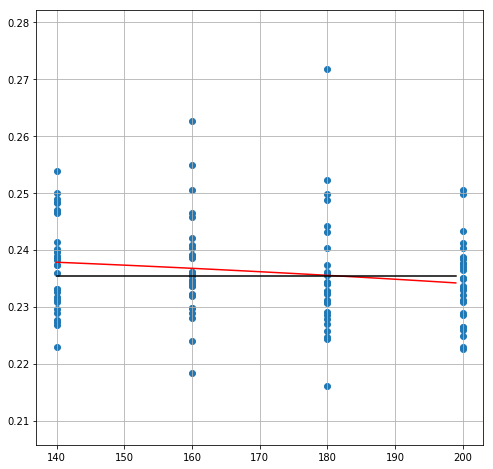

Using TensorFlow backend.


181
FishIsland fco2


A Jupyter Widget

Models:  [['H'], ['Wind Spd'], ['air pressure'], ['Ta'], ['Rn'], ['PPFD'], ['Rain'], ['Water Table'], ['Ts 2.5 cm'], ['Ts 15 cm'], ['VWC'], ['Active Layer'], ['24H Rain'], ['Wtr Tbl Trnd']]
Number of Models:  14


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  1
    Model        R2       MAE  Level        SE
Key                                           
1_5  PPFD  0.409655  0.062283      1  0.000051
Models:  [['H', 'PPFD'], ['Wind Spd', 'PPFD'], ['air pressure', 'PPFD'], ['Ta', 'PPFD'], ['Rn', 'PPFD'], ['PPFD', 'Rain'], ['PPFD', 'Water Table'], ['PPFD', 'Ts 2.5 cm'], ['PPFD', 'Ts 15 cm'], ['PPFD', 'VWC'], ['PPFD', 'Active Layer'], ['PPFD', '24H Rain'], ['PPFD', 'Wtr Tbl Trnd']]
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  2
                  Model        R2       MAE  Level        SE
Key                                                         
2_10  PPFD+Active Layer  0.484223  0.057834      2  0.000091
Should we exit?? 0.0579249075659 0.0622829525676
Models:  [['H', 'PPFD', 'Active Layer'], ['Wind Spd', 'PPFD', 'Active Layer'], ['air pressure', 'PPFD', 'Active Layer'], ['Ta', 'PPFD', 'Active Layer'], ['Rn', 'PPFD', 'Active Layer'], ['PPFD', 'Rain', 'Active Layer'], ['PPFD', 'Water Table', 'Active Layer'], ['PPFD', 'Ts 2.5 cm', 'Active Layer'], ['PPFD', 'Ts 15 cm', 'Active Layer'], ['PPFD', 'VWC', 'Active Layer'], ['PPFD', 'Active Layer', '24H Rain'], ['PPFD', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  3
                           Model        R2       MAE  Level        SE
Key                                                                  
3_7  PPFD+Ts 2.5 cm+Active Layer  0.572815  0.053439      3  0.000138
Should we exit?? 0.0535771514654 0.057834120839
Models:  [['H', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['Wind Spd', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['Ta', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['Rn', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['PPFD', 'Rain', 'Ts 2.5 cm', 'Active Layer'], ['PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer'], ['PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['PPFD', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['PPFD', 'Ts 2.5 cm', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  4
                             Model        R2       MAE  Level        SE
Key                                                                    
4_0  H+PPFD+Ts 2.5 cm+Active Layer  0.596879  0.052556      4  0.000152
Should we exit?? 0.0527081162935 0.0534393849402
Models:  [['H', 'Wind Spd', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['H', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Rn', 'PPFD', 'Ts 2.5 cm', 'Active Layer'], ['H', 'PPFD', 'Rain', 'Ts 2.5 cm', 'Active Layer'], ['H', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer'], ['H', 'PPFD', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['H', 'PPFD', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  5
                                         Model        R2       MAE  Level  \
Key                                                                         
5_5  H+PPFD+Water Table+Ts 2.5 cm+Active Layer  0.624871  0.051196      5   

          SE  
Key           
5_5  0.00028  
Should we exit?? 0.0514760651556 0.0525563459285
Models:  [['H', 'Wind Spd', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'air pressure', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Ta', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Rn', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'PPFD', 'Rain', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer'], ['H', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['H', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  6
                                                 Model        R2       MAE  \
Key                                                                          
6_0  H+Wind Spd+PPFD+Water Table+Ts 2.5 cm+Active L...  0.690391  0.049118   

     Level        SE  
Key                   
6_0      6  0.000211  
Should we exit?? 0.0493288441461 0.0511956144699
Models:  [['H', 'Wind Spd', 'air pressure', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Rn', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'PPFD', 'Rain', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'PPFD', 'Water Table', 'Ts 2.5 cm', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'PPFD', 'Water Table', 'Ts 2.5 cm

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  7
                                                 Model        R2       MAE  \
Key                                                                          
7_5  H+Wind Spd+PPFD+Water Table+Ts 2.5 cm+VWC+Acti...  0.687449  0.048886   

     Level        SE  
Key                   
7_5      7  0.000238  
Should we exit?? 0.0491249748565 0.0491178910087
Exit Early
['H+Wind Spd+PPFD+Water Table+Ts 2.5 cm+Active Layer']       Key  Level       MAE                                              Model  \
0     1_0      1  0.070497                                                  H   
1     1_0      1  0.069919                                                  H   
2     1_0      1  0.069546                                                  H   
3     1_0      1  0.069171                                                  H   
4     1_0      1  0.070485                                                  H   
5     1_0      1  0.069599                                               

A Jupyter Widget

Using TensorFlow backend.


Leaving at  140


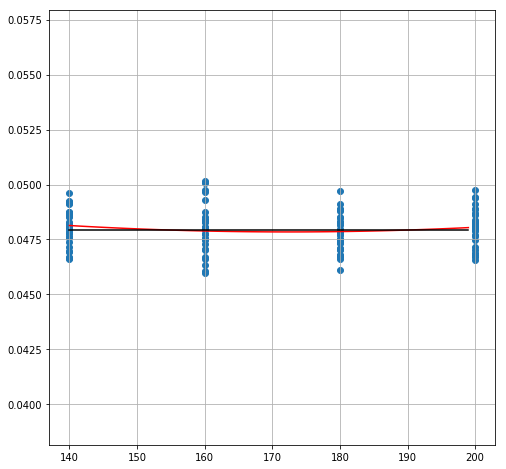

Using TensorFlow backend.


155
FishIsland fch4


A Jupyter Widget

Models:  [['H'], ['Wind Spd'], ['air pressure'], ['Ta'], ['Rn'], ['PPFD'], ['Rain'], ['Water Table'], ['Ts 2.5 cm'], ['Ts 15 cm'], ['VWC'], ['Active Layer'], ['24H Rain'], ['Wtr Tbl Trnd']]
Number of Models:  14


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  1
    Model        R2       MAE  Level        SE
Key                                           
1_0     H -2.001093  0.567885      1  0.000299
Models:  [['H', 'Wind Spd'], ['H', 'air pressure'], ['H', 'Ta'], ['H', 'Rn'], ['H', 'PPFD'], ['H', 'Rain'], ['H', 'Water Table'], ['H', 'Ts 2.5 cm'], ['H', 'Ts 15 cm'], ['H', 'VWC'], ['H', 'Active Layer'], ['H', '24H Rain'], ['H', 'Wtr Tbl Trnd']]
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  2
               Model        R2       MAE  Level        SE
Key                                                      
2_10  H+Active Layer -1.026304  0.529161      2  0.000367
Should we exit?? 0.529527999721 0.567885483006
Models:  [['H', 'Wind Spd', 'Active Layer'], ['H', 'air pressure', 'Active Layer'], ['H', 'Ta', 'Active Layer'], ['H', 'Rn', 'Active Layer'], ['H', 'PPFD', 'Active Layer'], ['H', 'Rain', 'Active Layer'], ['H', 'Water Table', 'Active Layer'], ['H', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Ts 15 cm', 'Active Layer'], ['H', 'VWC', 'Active Layer'], ['H', 'Active Layer', '24H Rain'], ['H', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  3
                       Model       R2       MAE  Level        SE
Key                                                             
3_0  H+Wind Spd+Active Layer -0.81838  0.510064      3  0.000724
Should we exit?? 0.51078850017 0.529161496704
Models:  [['H', 'Wind Spd', 'air pressure', 'Active Layer'], ['H', 'Wind Spd', 'Ta', 'Active Layer'], ['H', 'Wind Spd', 'Rn', 'Active Layer'], ['H', 'Wind Spd', 'PPFD', 'Active Layer'], ['H', 'Wind Spd', 'Rain', 'Active Layer'], ['H', 'Wind Spd', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  4
                                    Model        R2       MAE  Level        SE
Key                                                                           
4_0  H+Wind Spd+air pressure+Active Layer -0.693198  0.494012      4  0.000849
Should we exit?? 0.494861222845 0.510064125563
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Rn', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'PPFD', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Rain', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Active Layer', 'Wtr Tbl Trnd']]
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  5
                                                Model        R2       MAE  \
Key                                                                         
5_4  H+Wind Spd+air pressure+Water Table+Active Layer -0.548851  0.480725   

     Level        SE  
Key                   
5_4      5  0.001189  
Should we exit?? 0.481914053721 0.494011754748
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Rn', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'PPFD', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Rain', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Water Table', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Water Table', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Water Table', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'a

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  6
                                                 Model       R2       MAE  \
Key                                                                         
6_0  H+Wind Spd+air pressure+Ta+Water Table+Active ... -0.45707  0.472662   

     Level        SE  
Key                   
6_0      6  0.002427  
Should we exit?? 0.4750895719 0.48072508068
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Rn', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Rain', 'Water Table', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 15 cm', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table'

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  7
                                                 Model        R2       MAE  \
Key                                                                          
7_5  H+Wind Spd+air pressure+Ta+Water Table+VWC+Act... -0.318697  0.467037   

     Level        SE  
Key                   
7_5      7  0.001933  
Should we exit?? 0.46896978364 0.472662314666
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Rn', 'Water Table', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Water Table', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Rain', 'Water Table', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 15 cm', 'VWC', 'Active Layer'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'VWC', 'Active Layer', 'Wtr Tb

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  8
                                                 Model        R2       MAE  \
Key                                                                          
8_5  H+Wind Spd+air pressure+Ta+Water Table+VWC+Act... -0.199196  0.459278   

     Level        SE  
Key                   
8_5      8  0.002259  
Should we exit?? 0.461536142314 0.467036721553
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Rn', 'Water Table', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Water Table', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Rain', 'Water Table', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 15 cm', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'VWC', 'Active Layer', '24H Rain', 'Wtr Tbl Trnd']]
Number o

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


Best Model @ Level  9
                                                 Model        R2       MAE  \
Key                                                                          
9_4  H+Wind Spd+air pressure+Ta+Water Table+Ts 15 c... -0.204513  0.456831   

     Level        SE  
Key                   
9_4      9  0.002124  
Should we exit?? 0.458954872107 0.459277501117
Models:  [['H', 'Wind Spd', 'air pressure', 'Ta', 'Rn', 'Water Table', 'Ts 15 cm', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Water Table', 'Ts 15 cm', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Rain', 'Water Table', 'Ts 15 cm', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', '24H Rain'], ['H', 'Wind Spd', 'air pressure', 'Ta', 'Water Table', 'Ts 15 cm', 'VWC', 'Active Layer', '24H Rain', 'Wtr Tbl Trnd']]
Number of Models:  5


A Jupyter Widget

Using TensorFlow backend.


Best Model @ Level  10
                                                  Model        R2       MAE  \
Key                                                                           
10_3  H+Wind Spd+air pressure+Ta+Water Table+Ts 2.5 ... -0.275939  0.461126   

      Level        SE  
Key                    
10_3     10  0.002649  
Should we exit?? 0.463775166613 0.456830810919
Exit Early
[ 'H+Wind Spd+air pressure+Ta+Water Table+Ts 15 cm+VWC+Active Layer+24H Rain']       Key  Level       MAE                                              Model  \
0     1_0      1  0.567917                                                  H   
1     1_0      1  0.566274                                                  H   
2     1_0      1  0.566542                                                  H   
3     1_0      1  0.566027                                                  H   
4     1_0      1  0.571881                                                  H   
5     1_0      1  0.566837                  

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


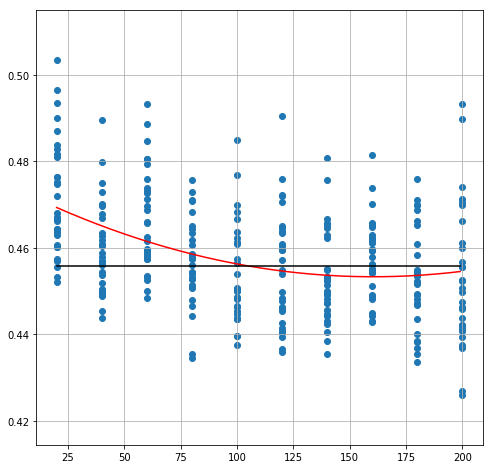

105


In [7]:
# pool.close()
# Site = 'Illisarvik'#'FishIsland'#
Scope = 'Full'
cwd = os.getcwd()
def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        BaseFactors = ['Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','wind_speed','air_pressure']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model,BaseFactors)

def Params(Func,Y,MP = True):
    params = {}
    params['proc']=3
    if MP == False:
        params['proc']=1
    if Func == 'Full':
        epochs = 200
        K = 30
        splits_per_mod = 1
        N = np.linspace(200,20,10,dtype='int32')
    elif Func == 'Test':
        epochs = 200
        K = 30
        splits_per_mod = 1
        N = np.linspace(70,10,5,dtype='int32')
    N = np.repeat(N,K)
    d = {'N':N.astype(int)}
    Runs = pd.DataFrame(data=d)
    Runs['MAE'] = 0.0
    Runs['R2'] = 0.0
    Runs['Model']=0
    params['K'] = K
    params['epochs'] = epochs
    params['Y'] = Y
    params['splits_per_mod'] = splits_per_mod
    params['Save'] = {}
    params['Save']['Weights']=False
    params['Save']['Model']=False
    
    return(Runs,params)


MP=True
if Scope == 'Full':
    MP = True
if __name__=='__main__'and MP==True:
    pool = Pool(processes=3,maxtasksperchild=75)
else:pool=None
    
for Site in ['Illisarvik','FishIsland']:
#     Site='Illisarvik'
#     FillVar = 'fco2'
    for FillVar in ['fco2','fch4']:
        print(Site,FillVar)
        FullModel,BaseFactors = ModSelect(Scope,Site)
        Runs,params = Params(Scope,FillVar,MP)
        params['Dpath'] = cwd+'/'+Site+'/'
        params['Prelim_N']=True
        Best,Scores,ModelRuns = FactorTest(params,FullModel,Runs,BaseFactors)
        print(Best,Scores)
        Scores,ModelRuns = Best_Fill(Best,Runs,Scores,params)
        Scores.to_csv(params['Dpath']+FillVar+'/GapFillingSummary.csv')
        ModelRuns.to_csv(params['Dpath']+FillVar+'/GapFilled.csv')

if __name__=='__main__'and MP==True:
    pool.close()

In [8]:
Grp = Scores.groupby('Model').mean()
Grp['SE'] = Scores[['Model','MAE']].groupby('Model').sem()
# Grp['SE'] = Scores[['Key','MAE']].groupby('Key').sem()
print(Grp)
# plt.bar(Grp.index,Grp['MAE'],yerr=Grp['SE'])

                                                    Level       MAE  \
Model                                                                 
24H Rain                                              1.0  0.743331   
Active Layer                                          1.0  0.676252   
H                                                     1.0  0.567885   
H+24H Rain                                            2.0  0.562922   
H+Active Layer                                        2.0  0.529161   
H+Active Layer+24H Rain                               3.0  0.530674   
H+Active Layer+Wtr Tbl Trnd                           3.0  0.531754   
H+PPFD                                                2.0  0.561504   
H+PPFD+Active Layer                                   3.0  0.519745   
H+Rain                                                2.0  0.567766   
H+Rain+Active Layer                                   3.0  0.529028   
H+Rn                                                  2.0  0.559136   
H+Rn+A